In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import os 
import PIL
import time

2021-10-19 21:46:59.108269: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-19 21:46:59.108289: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
dataset_name = 'diabetic_retinopathy_detection/btgraham-300'
subdataset_name = 'btgraham-300'
print(dataset_name)

diabetic_retinopathy_detection/btgraham-300


In [3]:
BATCH_SIZE = 256

In [4]:
tfds.__version__

'3.0.0'

In [5]:

dataset, info= tfds.load(dataset_name,split=tfds.Split.TRAIN, download=True, with_info=True)
#dataset = dataset.map(lambda image: tf.image.resize_with_crop_or_pad(image, 64, 64))
print(type(dataset))


2021-10-19 21:47:05.794051: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-19 21:47:05.794081: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-19 21:47:05.794104: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (juanpablo): /proc/driver/nvidia/version does not exist
2021-10-19 21:47:05.794428: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


In [6]:
print(dataset.__len__())

tf.Tensor(35126, shape=(), dtype=int64)


In [7]:
IMG_SIZE = 300

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

# Ejemplo de uso
# result = resize_and_rescale(image['image'])
# _ = plt.imshow(result)

In [27]:
batch_size = BATCH_SIZE
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x: (resize_and_rescale(x['image'])), 
              num_parallel_calls=AUTOTUNE)

  #if shuffle:
  #  ds = ds.shuffle(1000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  #if augment:
  #  ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
  #              num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [11]:
def make_generator_model():
  aKernelSize = 5
  aStrides = 2
  z_dim = 100

  layersInfo = [(4, 1024), (8, 512), (16,256), (32, 128), (64, 3)]
  
  layer_0 = (4, 1024)
  model = tf.keras.Sequential()
  model.add(layers.Dense(layer_0[0] ** 2 * layer_0[1], use_bias=False, input_shape=(z_dim,), name='gen_1'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  
  model.add(layers.Reshape((layer_0[0], layer_0[0], layer_0[1])))
  print(model.output_shape)
  assert model.output_shape == (None, layer_0[0], layer_0[0], layer_0[1])  # Note: None is the batch size

  layer_1 = layersInfo[1]
  model.add(layers.Conv2DTranspose(layer_1[1], kernel_size=aKernelSize, strides=aStrides, padding='same', use_bias=False, name='gen_2'))
  print(model.output_shape)
  assert model.output_shape == (None, layer_1[0], layer_1[0], layer_1[1])
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  layer_2 = layersInfo[2]
  model.add(layers.Conv2DTranspose(layer_2[1], kernel_size=aKernelSize, strides=aStrides, padding='same', use_bias=False, name='gen_3'))
  assert model.output_shape == (None, layer_2[0], layer_2[0], layer_2[1])
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  layer_3 = layersInfo[3]
  model.add(layers.Conv2DTranspose(layer_3[1], kernel_size=aKernelSize, strides=aStrides, padding='same', use_bias=False, name='gen_4'))
  assert model.output_shape == (None, layer_3[0], layer_3[0], layer_3[1])
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  layer_4 = layersInfo[4]
  model.add(layers.Conv2DTranspose(layer_4[1], kernel_size=aKernelSize, strides=aStrides, padding='same', use_bias=False, activation='tanh', name='gen_5'))
  assert model.output_shape == (None, layer_4[0], layer_4[0], layer_4[1])

  return model

(None, 4, 4, 1024)
(None, 8, 8, 512)


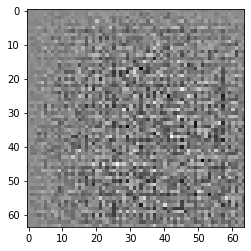

In [12]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [13]:
def make_discriminator_model():
  aKernelSize = 5
  aStrides = 2
  dropOutRatio = 0.3

  layersInfo = [(32, 64), (16,128), (8, 256), (4, 512)]
  
  model = tf.keras.Sequential()
  
  layer_0 = layersInfo[0]
  model.add(layers.Conv2D(layer_0[1], kernel_size=aKernelSize, strides=aStrides, padding='same', input_shape=[64, 64, 3], name='dis_1'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(dropOutRatio))

  layer_1 = layersInfo[1]
  model.add(layers.Conv2D(layer_1[1], kernel_size=aKernelSize, strides=aStrides, padding='same', name='dis_2'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(dropOutRatio))

  layer_2 = layersInfo[2]
  model.add(layers.Conv2D(layer_2[1], kernel_size=aKernelSize, strides=aStrides, padding='same', name='dis_3'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(dropOutRatio))

  layer_3 = layersInfo[3]
  model.add(layers.Conv2D(layer_3[1], kernel_size=aKernelSize, strides=aStrides, padding='same', name='dis_4'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(dropOutRatio))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [14]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[7.429183e-05]], shape=(1, 1), dtype=float32)


In [15]:
print(discriminator.layers)

[<keras.layers.convolutional.Conv2D object at 0x7f6a654deb50>, <keras.layers.advanced_activations.LeakyReLU object at 0x7f6a65a69a00>, <keras.layers.core.Dropout object at 0x7f6a65a413a0>, <keras.layers.convolutional.Conv2D object at 0x7f6a654721c0>, <keras.layers.advanced_activations.LeakyReLU object at 0x7f6a65472310>, <keras.layers.core.Dropout object at 0x7f6a9f023e80>, <keras.layers.convolutional.Conv2D object at 0x7f6a653f7dc0>, <keras.layers.advanced_activations.LeakyReLU object at 0x7f6a653f7040>, <keras.layers.core.Dropout object at 0x7f6a653fc790>, <keras.layers.convolutional.Conv2D object at 0x7f6a65405ee0>, <keras.layers.advanced_activations.LeakyReLU object at 0x7f6a6540cbe0>, <keras.layers.core.Dropout object at 0x7f6a65405880>, <keras.layers.core.Flatten object at 0x7f6a653fcf40>, <keras.layers.core.Dense object at 0x7f6a65414520>]


In [16]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [19]:
learing_rate = 1e-4
generator_optimizer = tf.keras.optimizers.Adam(learing_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(learing_rate)

In [20]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [21]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [22]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [23]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [24]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [25]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch

In [29]:
train_dataset = prepare(dataset).batch(BATCH_SIZE)
train(train_dataset, EPOCHS)

ValueError: in user code:

    /tmp/ipykernel_156546/3248131820.py:10 train_step  *
        real_output = discriminator(images, training=True)
    /home/juan/.local/lib/python3.8/site-packages/keras/engine/base_layer.py:1037 __call__  **
        outputs = call_fn(inputs, *args, **kwargs)
    /home/juan/.local/lib/python3.8/site-packages/keras/engine/sequential.py:369 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /home/juan/.local/lib/python3.8/site-packages/keras/engine/functional.py:414 call
        return self._run_internal_graph(
    /home/juan/.local/lib/python3.8/site-packages/keras/engine/functional.py:550 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /home/juan/.local/lib/python3.8/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/juan/.local/lib/python3.8/site-packages/keras/engine/input_spec.py:250 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense is incompatible with the layer: expected axis -1 of input shape to have value 8192 but received input with shape (256, 184832)
